In [1]:
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
# Create Spark Session
spark = SparkSession.builder \
    .appName("BicicletasDatos") \
    .getOrCreate()


In [3]:
from google.colab import files
uploaded = files.upload()

Saving 2025_02.csv to 2025_02.csv


In [4]:
#read file
df_spark = spark.read.csv("2025_02.csv", header=True, inferSchema=True)

In [5]:
# Show Schema
df_spark.printSchema()

root
 |-- Genero_Usuario: string (nullable = true)
 |-- Edad_Usuario: string (nullable = true)
 |-- Bici: integer (nullable = true)
 |-- Ciclo_Estacion_Retiro: string (nullable = true)
 |-- Fecha_Retiro: string (nullable = true)
 |-- Hora_Retiro: timestamp (nullable = true)
 |-- Ciclo_EstacionArribo: string (nullable = true)
 |-- Fecha_Arribo: string (nullable = true)
 |-- Hora_Arribo: timestamp (nullable = true)



In [6]:
# Convert to Pandas Dataframe for data preprocessing
df = df_spark.toPandas()


In [7]:
# Convert Gender tu numeric values encoded
le = LabelEncoder()
df['Genero_Usuario'] = le.fit_transform(df['Genero_Usuario'])  # M a 1, F a 0

In [8]:
import pandas as pd
# Make sume adjustments for training
df['Hora_Retiro'] = pd.to_datetime(df['Hora_Retiro'], format='%H:%M:%S', errors='coerce')

# Create a objective variable (1 is Bike was used overnight, 0 on the contrary)
# Get to know if the retire Hour is a Timestamp and compare to the hour treshold
df['Usa_Bici_Noche'] = df['Hora_Retiro'].apply(lambda x: 1 if x.time() >= pd.to_datetime('22:00:00').time() else 0)

In [9]:
# See the unique values on the columns gender and age 'Genero_Usuario' y 'Edad_Usuario'
print("Valores únicos de 'Genero_Usuario':", df['Genero_Usuario'].unique())
print("Valores únicos de 'Edad_Usuario':", df['Edad_Usuario'].unique())

# Replace 'NULL' for NaN for data cleaning
df.replace('NULL', pd.NA, inplace=True)

# Convert column Age to numeric
df['Edad_Usuario'] = pd.to_numeric(df['Edad_Usuario'], errors='coerce')

# Delete rows with NaN in characteristics and labels
df.dropna(subset=['Genero_Usuario', 'Edad_Usuario', 'Usa_Bici_Noche'], inplace=True)

# See how many rows left after cleaning
print(f'Número total de filas después de la limpieza: {df.shape[0]}')

Valores únicos de 'Genero_Usuario': [2 1 4 0 3]
Valores únicos de 'Edad_Usuario': ['43' '29' '22' '46' '23' '37' '21' '18' '28' '20' '27' '24' '62' '31'
 '25' '35' '30' '38' '45' '34' '36' '33' '39' '41' '53' '32' '19' '26'
 '51' '54' '58' '60' '40' '50' '69' '57' '42' '55' '44' '66' '48' '47'
 '61' '70' '49' '52' '59' '56' '64' '72' '73' '17' '63' '68' '100' '82'
 '65' '67' '91' '76' '71' '75' '77' '74' '102' '79' '80' '83' '16' '94'
 '78' 'NULL' '124' '99' '90' '101' '81' '85' '89' '95' '84' '143']
Número total de filas después de la limpieza: 1745522


In [10]:
# Put X and y variables for data training
X = df[['Genero_Usuario', 'Edad_Usuario']]
y = df['Usa_Bici_Noche']

In [11]:
# Split the dataset in training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Create and Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Test the model
accuracy = model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy: 96.05%


In [14]:
# Make predictions
predicciones = model.predict(X_test)
print(f'Predicciones: {predicciones}')

Predicciones: [0 0 0 ... 0 0 0]


In [15]:
import plotly.express as px

# Calculate the  DataFrame for confussin Matrix
cm = confusion_matrix(y_test, predicciones)
cm_df = pd.DataFrame(cm, index=['Does not use bicycle at night', 'Uses Bicycle at night'],
                     columns=['Does not use bicycle at night', 'Uses Bicycle at night'])

# Crear el gráfico
fig = px.imshow(cm_df, text_auto=True, color_continuous_scale='Greens',
                labels=dict(x="Predicted", y="Real", color="Conteo"),
                x=['Does not use bicycle at night', 'Uses Bicycle at night'],
                y=['Does not use bicycle at night', 'Uses Bicycle at night'])
fig.update_layout(title='Confussion Matrix')
fig.show()

In [16]:
# Calcular y mostrar el classification report
report = classification_report(y_test, predicciones)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    335301
           1       0.00      0.00      0.00     13804

    accuracy                           0.96    349105
   macro avg       0.48      0.50      0.49    349105
weighted avg       0.92      0.96      0.94    349105



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [17]:
# Crear un DataFrame para la comparativa
comparativa_df = pd.DataFrame({
    'Real': y_test.reset_index(drop=True),    # Datos reales
    'Predicted': predicciones                 # Predicciones del modelo
})


In [18]:
# Texto explicativo sobre la tabla
print("Comparison table:")
print("Note: In this table, the value '0' indicates that the user does NOT use the bicycle at night., "
      "while the value '1' indicates that the user DOES use the bicycle at night.\n")

# Mostrar la tabla comparativa
comparativa_df.head(20)

Comparison table:
Note: In this table, the value '0' indicates that the user does NOT use the bicycle at night., while the value '1' indicates that the user DOES use the bicycle at night.



,Real,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


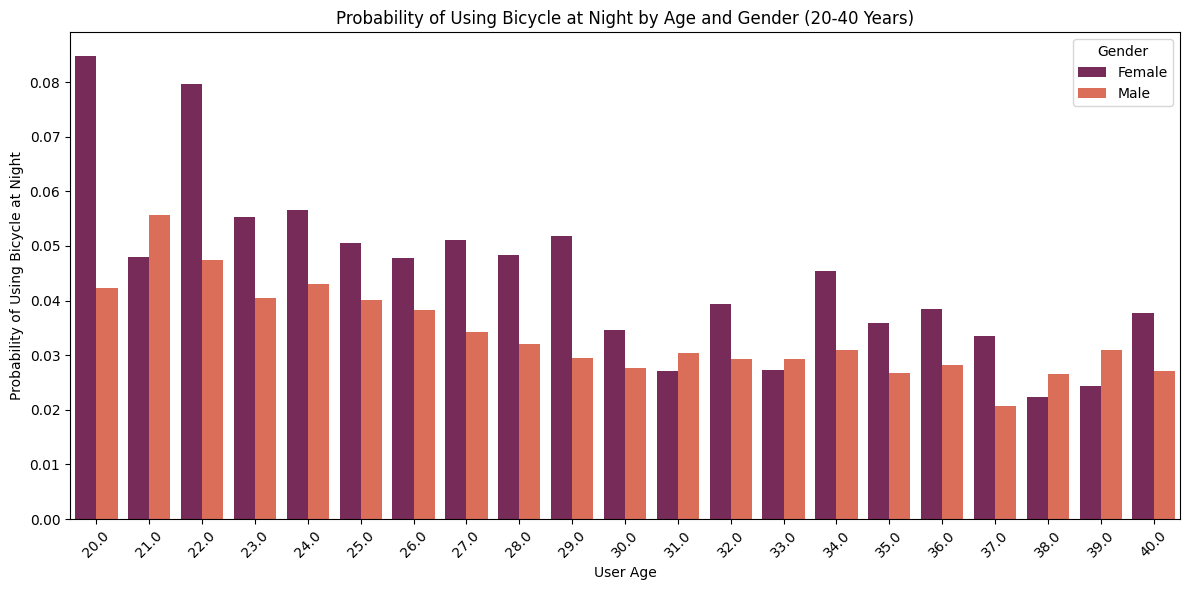

In [24]:
# Filter the DataFrame to include only ages between 20 and 40
filtered_df = df[(df['Edad_Usuario'] >= 20) & (df['Edad_Usuario'] <= 40)]

# Group by gender and age to find the average probability
grouped = filtered_df.groupby(['Genero_Usuario', 'Edad_Usuario'])['Prob_Usa_Bici_Noche'].mean().reset_index()

# Map gender to text for better interpretation
grouped['Genero_Usuario'] = grouped['Genero_Usuario'].map({1: 'Male', 0: 'Female'})

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Edad_Usuario', y='Prob_Usa_Bici_Noche', hue='Genero_Usuario', palette='rocket')
plt.title('Probability of Using Bicycle at Night by Age and Gender (20-40 Years)')
plt.xlabel('User Age')
plt.ylabel('Probability of Using Bicycle at Night')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()